# QBAF-Py: Examples

This noteboook provides some examples for how to use QBAF-Py.

## Instantiating QBAFs

Let us first instantiate a QBAF.

In [1]:
from qbaf import QBAFramework, QBAFARelations

args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.5, 0.2, 0.85, 0.65, 0.4, 1]
atts = [('c', 'a'), ('e', 'b'), ('f', 'c')]
supps = [('b', 'a'), ('d', 'a'), ('e', 'c')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


The semantics that will later be applied is tied to the QBAF instantiation.
Here, we specify the quadratic energy semantics.
Note that QBAF-Py is for argumentation-based reasoning and not for visualization, so we have to take care of the visualization ourself; in the function that we implement below, we also take care of the visualization of explanations.

In [2]:
%%capture
# To visualize the QBAFs, the networkx and pygraphviz libraries are required.
# We install them below, but depending on your setup, you may need to install them differently
!pip install networkx
!pip install pygraphviz

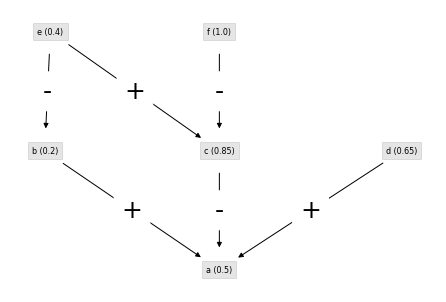

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def visualize(qbaf: QBAFramework, explanations=[], with_fs=False, round_to=2):
    """
    Takes a QBAF and renders it as a graph
    
    Args:
            qbaf (QBAFramework): The QBAF that is supposed to be rendered
            explanations (List): List of sets of explanation arguments that are supposed to be highlighted
            with_fs (Bool): Set to `True` if final strenghts should be rendered as well.
                            Defaults to `False`.
            round_to (int): Number of decimals the strengths should be rounded to before rendering.
                            Defaults to `2`.
            
    """
    args = qbaf.arguments
    initial_strengths = qbaf.initial_strengths
    for key, value in initial_strengths.items():
        initial_strengths[key] = round(value, round_to)
    if with_fs:
        final_strengths = qbaf.final_strengths
        for key, value in final_strengths.items():
            final_strengths[key] = round(value, round_to)
    graph = nx.DiGraph()
    nodes = {}
    edge_colors = []
    node_sizes = []
    for arg in args:
        if with_fs:
            label = f'{arg} ({initial_strengths[arg]}): {final_strengths[arg]}'
        else:
            label = f'{arg} ({initial_strengths[arg]})'
        graph.add_node(label)
        nodes[arg] = label
        edge_color = '#fff'
        node_size = 2000
        for explanation in explanations:
            if arg in explanation:
                edge_color = '#af4154'
                node_size = 3000
        node_sizes.append(node_size)
        edge_colors.append(edge_color)
    labels = {}
    for att in qbaf.attack_relations.relations:
        labels[(nodes[att[0]], nodes[att[1]])] = '-'
        graph.add_edge(nodes[att[0]], nodes[att[1]])
    for supp in qbaf.support_relations.relations:
        labels[(nodes[supp[0]], nodes[supp[1]])] = '+'
        graph.add_edge(nodes[supp[0]], nodes[supp[1]])
    pos = graphviz_layout(graph, prog='dot')
    nx.draw(graph, pos, with_labels=True, node_shape='8', node_size=node_sizes, font_size=8, node_color='#fff', edgecolors=edge_colors,bbox=dict(facecolor='black', alpha=0.1))
    nx.draw_networkx_edge_labels(
    graph, pos,
    edge_labels=labels,
    font_size=25,
    rotate=False)

visualize(qbaf_0)


## Drawing Inferences

As we have instantiated our QBAF with a specific semantics, the inferences (final strengths) are readily available:

In [4]:
final_strengths = qbaf_0.final_strengths
print(final_strengths)

{'f': 1.0, 'e': 0.4, 'c': 0.625, 'b': 0.1724137931034483, 'd': 0.65, 'a': 0.5187551724162596}


We update the visualizations to also show the final strengths of the arguments.
For this, we call our visualization function, with the parameter `with_fs` set to `True`.

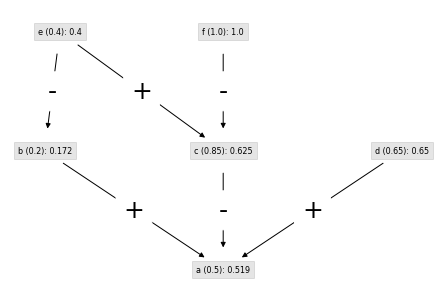

In [5]:
visualize(qbaf_0, with_fs=True, round_to=3)

## Generating Explanations

Given two argumentation frameworks and two arguments therein (so-called *topic arguments*), we can explain changes in the relative strength of these arguments (see: Kampik and Čyras. [Explaining Change in Quantitative Bipolar Argumentation](https://www.diva-portal.org/smash/get/diva2:1690830/FULLTEXT02). First, we instantiate two QBAFs and compute their final strengths; note that here, we use a naive semantics (`basic_model`), which simply subtracts the final strengths of attackers and adds the final strength of supporters.

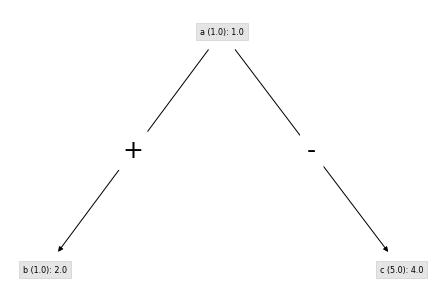

In [6]:
args_1 = ['a', 'b', 'c']
initial_strengths_1 = [1, 1, 5]
atts_1 = [('a', 'c')]
supps_1 = [('a', 'b')]
qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics="basic_model")

args_2 = ['a', 'b', 'c', 'd', 'e']
initial_strengths_2 = [2, 1, 5, 1, 3]
atts_2 = [('a', 'c'), ('d', 'a'), ('e', 'c')]
supps_2 = [('a', 'b'), ('d', 'e')]
qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics="basic_model")

visualize(qbaf_1, with_fs=True)

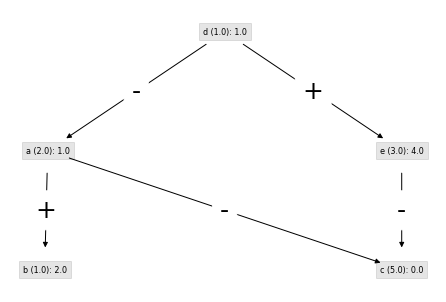

In [7]:
visualize(qbaf_2, with_fs=True)

As we can see, `b` is strength-inconsistent w.r.t. `c` (and `qbaf_1`, `qbaf_2`):

In [8]:
print(f'Are a and b strenght-consistent? {qbaf_1.are_strength_consistent(qbaf_2, "b", "c")}')

Are a and b strenght-consistent? False


Now, we can determine and visualize strength inconsistency explanations.

Minimal sufficient explanations: [{'a'}, {'e'}]


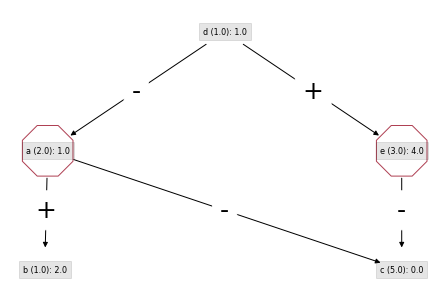

In [9]:
min_sufficient_explanations = qbaf_1.minimalSSIExplanations(qbaf_2, 'b', 'c')
print(f'Minimal sufficient explanations: {min_sufficient_explanations}')
visualize(qbaf_2, explanations=min_sufficient_explanations, with_fs=True)

Minimal counterfactual explanations: [{'e'}]


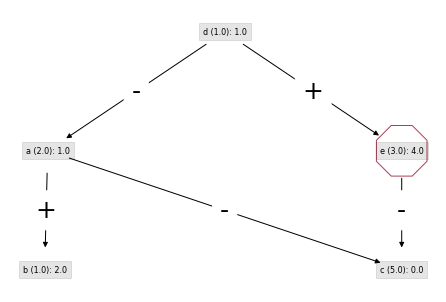

In [10]:
min_counterfactual_explanations = qbaf_1.minimalCSIExplanations(qbaf_2, 'b', 'c')
print(f'Minimal counterfactual explanations: {min_counterfactual_explanations}')
visualize(qbaf_2, explanations=min_counterfactual_explanations, with_fs=True)

## QBAF Arguments

Let us introduce the class QBAFArgument.

Note: Any object that is hashable can be used as argument (string, int, ...).

In [11]:
from qbaf import QBAFArgument

a = QBAFArgument(name='a', description='Shares from company X should be bought')
print(f"{a}")
print(f"{a = }")
print(f'{a.name = }')
print(f'{a.description = }')

Arg('a')
a = 'a'
a.name = 'a'
a.description = 'Shares from company X should be bought'


The attribute name is unmodifiable, whereas the attribute description is optional and modifiable.

In [12]:
b = QBAFArgument('b')
print(f'{b.name = }')

b.description = 'Shares from company X should be sold'
print(f'{b.description = }')

b.name = 'b'
b.description = 'Shares from company X should be sold'


Two arguments are equal iff their names are equal.

In [13]:
print(f'{a == b = }')

print(f"{a == QBAFArgument('a', 'Different description') = }")

a == b = False
a == QBAFArgument('a', 'Different description') = True


## QBAF semantics

The semantics can be selected only in the initialization of a QBAF.

The semantics is an optional argument that can be consulted with default value 'basic_model'.

In [14]:
args = ['a', 'b', 'c']
istrengths = [1, 1, 5]
att = [('a', 'c')]
supp = [('a', 'b')]
qbf = QBAFramework(args, istrengths, att, supp)

print(f'{qbf.semantics = }')

qbf.semantics = 'basic_model'


There are several semantics to choose from.
Each one with its one implementation of aggregation and influence functions.

In [15]:
for semantics in ["basic_model", "QuadraticEnergy_model", "SquaredDFQuAD_model",
                  "EulerBasedTop_model", "EulerBased_model", "DFQuAD_model"]:
    qbf_0 = QBAFramework(arguments=['a', 'b', 'c', 'd', 'e', 'f'],
                         initial_strengths=[0.5, 0.2, 0.85, 0.65, 0.4, 1],
                         attack_relations=[('c', 'a'), ('e', 'b'), ('f', 'c')],
                         support_relations=[('b', 'a'), ('d', 'a'), ('e', 'c')],
                         semantics=semantics)
    final_strengths = {arg: round(fs, 2) for arg, fs in qbf_0.final_strengths.items()}
    print(f"{semantics}'s final strengths: {final_strengths}")

basic_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.25, 'b': -0.2, 'd': 0.65, 'a': 0.7}
QuadraticEnergy_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.62, 'b': 0.17, 'd': 0.65, 'a': 0.52}
SquaredDFQuAD_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.53, 'b': 0.14, 'd': 0.65, 'a': 0.35}
EulerBasedTop_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.81, 'b': 0.15, 'd': 0.65, 'a': 0.47}
EulerBased_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.81, 'b': 0.15, 'd': 0.65, 'a': 0.5}
DFQuAD_model's final strengths: {'f': 1.0, 'e': 0.4, 'c': 0.34, 'b': 0.12, 'd': 0.65, 'a': 0.37}


## QBAF custom semantics

Your own semantics can be used by implementing your own aggregation and influence functions.

Optionally, you can set a max and min value for the initial strengths of your semantics.

In [16]:
qbf_0 = QBAFramework(arguments=['a', 'b', 'c', 'd', 'e', 'f'],
                      initial_strengths=[0.5, 0.2, 0.85, 0.65, 0.4, 1],
                      attack_relations=[('c', 'a'), ('e', 'b'), ('f', 'c')],
                      support_relations=[('b', 'a'), ('d', 'a'), ('e', 'c')],
                      aggregation_function=lambda w1, w2 : w1 + w2,
                      influence_function=lambda w, s : w + s,
                      min_strength=-1.7976931348623157e+308,
                      max_strength=1.7976931348623157e+308)
print("Custom implementation of basic_model")
print(f'{qbf_0.semantics = }')
print(f'{qbf_0.min_strength = }')
print(f'{qbf_0.max_strength = }')
print(f'{qbf_0.final_strengths = }')

Custom implementation of basic_model
qbf_0.semantics = None
qbf_0.min_strength = -1.7976931348623157e+308
qbf_0.max_strength = 1.7976931348623157e+308
qbf_0.final_strengths = {'f': 1.0, 'e': 0.4, 'c': 0.25, 'b': -0.2, 'd': 0.65, 'a': 0.7}


## QBAF disjoint relations

Since it does not make much sense to have one argument attacking and supporting at the same time another argument, the property disjoint_relations has been added that is activated when its value is True (default).
If it is activated, it checks that the attack and support relations are disjoint.

In [17]:
args,initial_strengths,att,supp = ['a', 'b', 'c'], [1, 1, 5], [('a', 'c')], [('a', 'b')]
qbf = QBAFramework(args,initial_strengths, att, att + supp,
                   semantics="basic_model",
                   disjoint_relations=False)
print(f'{qbf.disjoint_relations = }')
print(f'{qbf.attack_relations.isdisjoint(qbf.support_relations) = }')

qbf.disjoint_relations = False
qbf.attack_relations.isdisjoint(qbf.support_relations) = False


In [18]:
# Now if we set the qbf to check if they are disjoint it will throw an Exception if they are not
try:
    qbf.disjoint_relations = True
except ValueError:
      print("Value error: attack_relations and support_relations are not disjoint")

Value error: attack_relations and support_relations are not disjoint


## QBAF Attributes

The QBAF contains arguments, attack relations, support relations and initial strengths.

### Arguments

Arguments can be consulted, added and removed.

Note that arguments that are contained in any attack/relation cannot be removed.
Also, adding arguments that already exist does nothing (it does not modify its initial strength).

In [19]:
args,initial_strengths,att,supp = ['a', 'b', 'c', 'd'], [1, 1, 5, 0], [('a', 'c')], [('a', 'b')]
qbf = QBAFramework(args,initial_strengths, att, supp)

print(f'{qbf.arguments = }')
print(f"{'a' in qbf.arguments = }")
print(f"{qbf.contains_argument('a') = }")

qbf.arguments = {'b', 'd', 'a', 'c'}
'a' in qbf.arguments = True
qbf.contains_argument('a') = True


In [20]:
qbf.remove_argument('d')
print("Remove argument 'd'")
print(f'{qbf.arguments = }')

qbf.add_argument('e', initial_strength=0) # initial_strength is optional. Defaults to 0.0
print("Add argument 'e'")
print(f'{qbf.arguments = }')

Remove argument 'd'
qbf.arguments = {'a', 'b', 'c'}
Add argument 'e'
qbf.arguments = {'a', 'b', 'c', 'e'}


### Attack/Support relations

Attack/Support relations can be consulted, added and removed.

They are instances of the class QBAFARelations, which represents a set of tuples of size 2.

In [21]:
args,initial_strengths,att,supp = ['a', 'b', 'c'], [1, 1, 5], [('a', 'c')], [('a', 'b')]
qbf = QBAFramework(args,initial_strengths, att, supp)

print(f'{qbf.attack_relations = }')
print(f'{qbf.support_relations = }')

print(f"{('a', 'c') in qbf.attack_relations = }")
print(f"{qbf.contains_attack_relation('a', 'c') = }")

print(f"{('b', 'a') in qbf.support_relations = }")
print(f"{qbf.contains_support_relation('b', 'a') = }")

qbf.attack_relations = QBAFARelations{('a', 'c')}
qbf.support_relations = QBAFARelations{('a', 'b')}
('a', 'c') in qbf.attack_relations = True
qbf.contains_attack_relation('a', 'c') = True
('b', 'a') in qbf.support_relations = False
qbf.contains_support_relation('b', 'a') = False


In [22]:
qbf.remove_attack_relation('a', 'c')
qbf.remove_support_relation('a', 'b')
print("Removing existing attack and support relations")

qbf.add_attack_relation('c', 'a')
qbf.add_support_relation('b', 'a')
print("Adding new attack and support relations")

print(f'{qbf.attack_relations = }')
print(f'{qbf.support_relations = }')

Removing existing attack and support relations
Adding new attack and support relations
qbf.attack_relations = QBAFARelations{('c', 'a')}
qbf.support_relations = QBAFARelations{('b', 'a')}


### Initial strengths

Initial strengths can be consulted and modified.

In [23]:
args,initial_strengths,att,supp = ['a', 'b', 'c'], [1, 1, 5], [('a', 'c')], [('a', 'b')]
qbf = QBAFramework(args,initial_strengths, att, supp)

print(f'{qbf.initial_strengths = }')
print(f"{qbf.initial_strength('a') = }")

qbf.initial_strengths = {'a': 1.0, 'b': 1.0, 'c': 5.0}
qbf.initial_strength('a') = 1.0


In [24]:
qbf.modify_initial_strength('a', 2)
print("Modify initial_strength of 'a'")

print(f'{qbf.initial_strengths = }')

Modify initial_strength of 'a'
qbf.initial_strengths = {'a': 2.0, 'b': 1.0, 'c': 5.0}


### Final strengths

Final strengths can be consulted and they are calculated making use of the aggregation and influence functions.

Every time the final strengths are calculated, they are stored so they can be used next time until the QBAF is modified.

When the final strengths are calculated, it is checked that the QBAF is acyclic. Otherwise, it throws and Exception.

In [25]:
args,initial_strengths,att,supp = ['a', 'b', 'c'], [1, 1, 5], [('a', 'c')], [('a', 'b')]
qbf = QBAFramework(args,initial_strengths, att, supp)

print(f'{qbf.isacyclic() = }')

print(f'{qbf.final_strengths = }')
print(f"{qbf.final_strength('a') = }")

qbf.isacyclic() = True
qbf.final_strengths = {'a': 1.0, 'b': 2.0, 'c': 4.0}
qbf.final_strength('a') = 1.0


## QBAF Additional functionality

Additional functionality regarding strength consistency, QBAF reversal and strength inconsistency explanations.

Note that when working with more than one QBAF, they are assumed to have the same semantics. It is not checked.

In [26]:
qbfa = QBAFramework(['a', 'b', 'c'], [2, 1, 5], [('a', 'c')], [('a', 'b')],
                   semantics="basic_model")

#qbfe = QBAFramework(['a', 'b', 'c', 'e'], [1, 1, 5, 3], [('a', 'c'), ('e', 'c')], [('a', 'b')])
qbfe = qbfa.copy()
qbfe.modify_initial_strength('a', 1)
qbfe.add_argument('e', 3)
qbfe.add_attack_relation('e', 'c')

print(f"{qbfa.final_strengths = }")
print(f"{qbfe.final_strengths = }")

qbfa.final_strengths = {'a': 2.0, 'b': 3.0, 'c': 3.0}
qbfe.final_strengths = {'a': 1.0, 'b': 2.0, 'e': 3.0, 'c': 1.0}


### Strength Consistency

It can be checked if two arguments are strength consistent w.r.t. two QBAFs.

In [27]:
print(f"{qbfe.are_strength_consistent(qbfa, 'b', 'c') = }")

qbfe.are_strength_consistent(qbfa, 'b', 'c') = False


### Reversal

QBAF Reversal of a set of arguments w.r.t. two QBAFs returns a new QBAF.

In [28]:
reversal = qbfe.reversal(qbfa, {'e'})

print(f"{reversal.final_strengths = }")

reversal.final_strengths = {'a': 1.0, 'b': 2.0, 'c': 4.0}


### Strength Inconsistency Explanation

It can be checked if a set of arguments is a Sufficient, Necessary or Counterfactual Strength Inconsistency Explanation of two arguments w.r.t. two QBAFs.

In [29]:
explanations = {"Sufficient SI Explanation": qbfe.isSSIExplanation(qbfa, {'e'}, 'b', 'c'),
                "Necessary SI Explanation": qbfe.isNSIExplanation(qbfa, {'e'}, 'b', 'c'),
                "Counterfactual SI Explanation": qbfe.isCSIExplanation(qbfa, {'e'}, 'b', 'c')}
for e in explanations:
    if explanations[e]:
        print("{'e'} is a %s of 'a' and 'b' w.r.t. qbfe and qbfa" % e)
    else:
        print("{'e'} is NOT a %s of 'a' and 'b' w.r.t. qbfe and qbfa" % e)

{'e'} is a Sufficient SI Explanation of 'a' and 'b' w.r.t. qbfe and qbfa
{'e'} is NOT a Necessary SI Explanation of 'a' and 'b' w.r.t. qbfe and qbfa
{'e'} is NOT a Counterfactual SI Explanation of 'a' and 'b' w.r.t. qbfe and qbfa


### $\subset$-minimal SI Explanations

All the $\subset$-minimal Sufficient, Necessary or Counterfactual Strength Inconsistency Explanation set of arguments can be computed w.r.t. two arguments and two QBAFs.

In [30]:
explanations = {"Sufficient SI Explanations": qbfe.minimalSSIExplanations(qbfa, 'b', 'c'),
                "Necessary SI Explanations": qbfe.minimalNSIExplanations(qbfa, 'b', 'c'),
                "Counterfactual SI Explanations": qbfe.minimalCSIExplanations(qbfa, 'b', 'c')}
for e in explanations:
    print("Subset-minimal %s of 'a' and 'b' w.r.t. qbfe and qbfa: %s" % (e, str(explanations[e])))

Subset-minimal Sufficient SI Explanations of 'a' and 'b' w.r.t. qbfe and qbfa: [{'a'}, {'e'}]
Subset-minimal Necessary SI Explanations of 'a' and 'b' w.r.t. qbfe and qbfa: [{'a', 'e'}]
Subset-minimal Counterfactual SI Explanations of 'a' and 'b' w.r.t. qbfe and qbfa: [{'a', 'e'}]


## Simple Removal

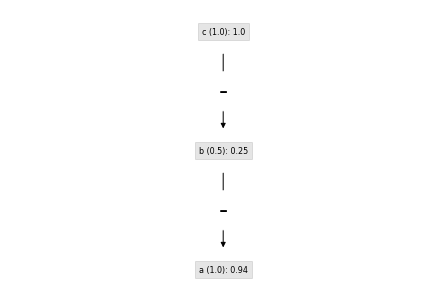

In [31]:
# QuadraticEnergy violates proximity
args = ['a', 'b', 'c']
initial_strengths = [1, 0.5, 1]
atts = [('b', 'a'), ('c', 'b')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

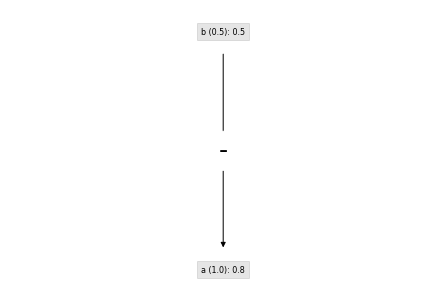

In [32]:
args = ['a', 'b']
initial_strengths = [1, 0.5]
atts = [('b', 'a')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

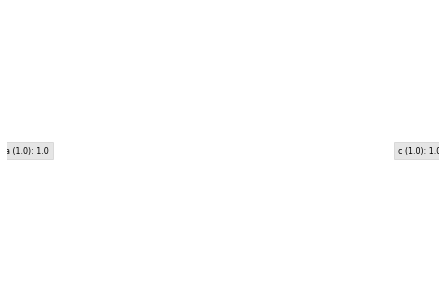

In [33]:
args = ['a', 'c']
initial_strengths = [1, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

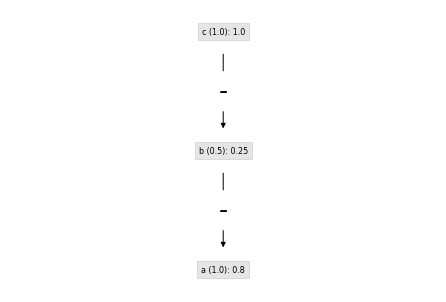

In [34]:
# SquaredDFQuAD violates proximity
args = ['a', 'b', 'c']
initial_strengths = [1, 0.5, 1]
atts = [('b', 'a'), ('c', 'b')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

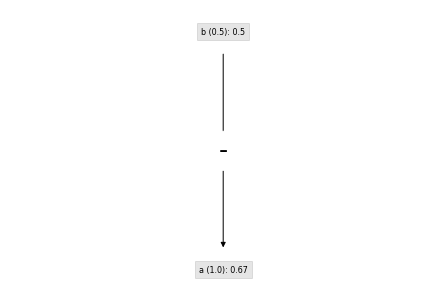

In [35]:
args = ['a', 'b']
initial_strengths = [1, 0.5]
atts = [('b', 'a')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

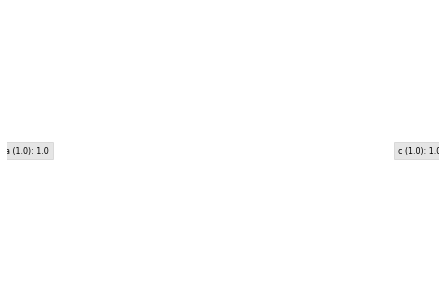

In [36]:
args = ['a', 'c']
initial_strengths = [1, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

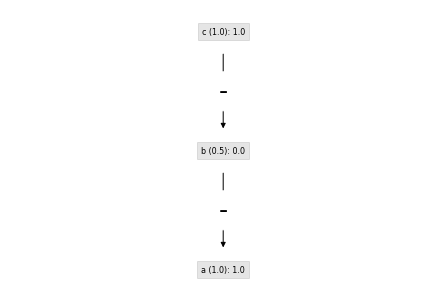

In [37]:
# DFQuAD violates proximity
args = ['a', 'b', 'c']
initial_strengths = [1, 0.5, 1]
atts = [('b', 'a'), ('c', 'b')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

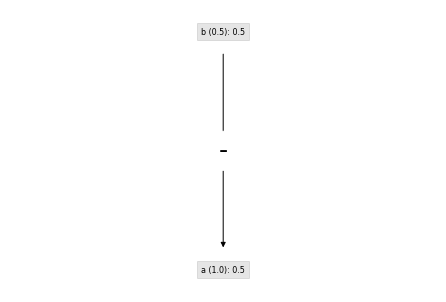

In [38]:
args = ['a', 'b']
initial_strengths = [1, 0.5]
atts = [('b', 'a')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

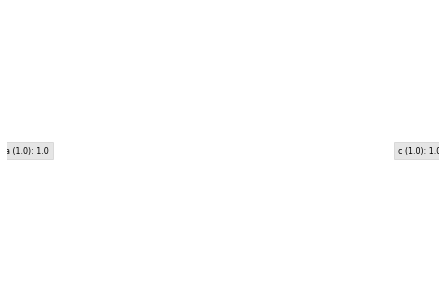

In [39]:
args = ['a', 'c']
initial_strengths = [1, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

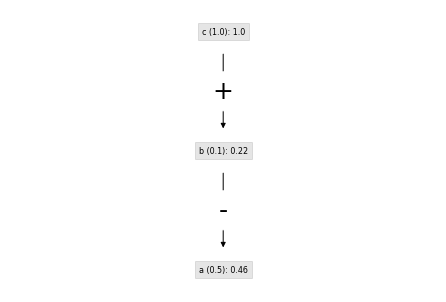

In [40]:
# EulerBased violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.1, 1]
atts = [('b', 'a')]
supps = [('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

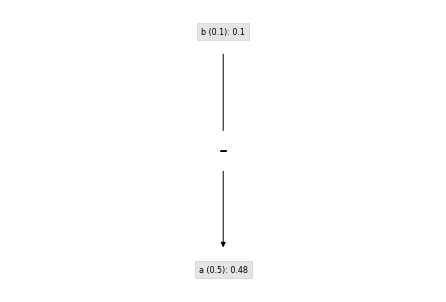

In [41]:
args = ['a', 'b']
initial_strengths = [0.5, 0.1]
atts = [('b', 'a')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

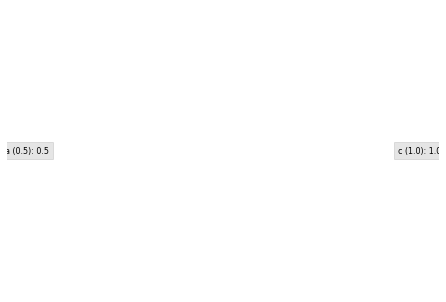

In [42]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

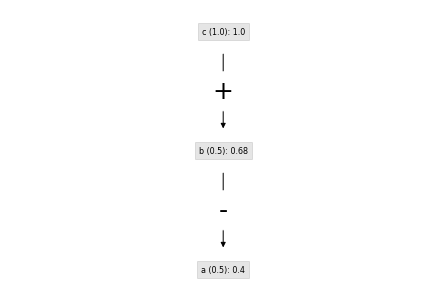

In [43]:
# EulerBasedTop_model violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.5, 1]
atts = [('b', 'a')]
supps = [('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

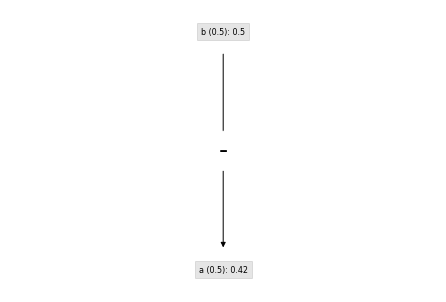

In [44]:
args = ['a', 'b']
initial_strengths = [0.5, 0.5]
atts = [('b', 'a')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

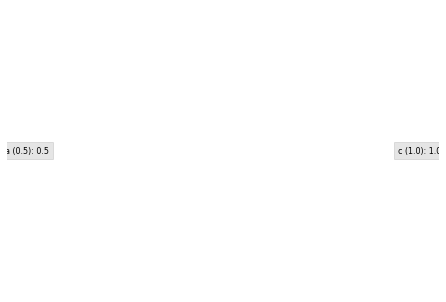

In [45]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

## Removal, Intrinsic Contribution

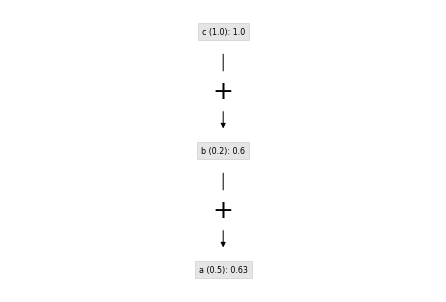

In [46]:
# QuadraticEnergy violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.2, 1]
atts = []
supps = [('b', 'a'), ('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

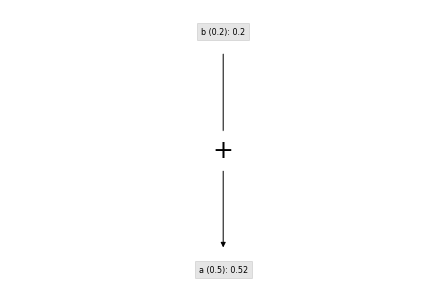

In [47]:
args = ['a', 'b']
initial_strengths = [0.5, 0.2]
atts = []
supps = [('b', 'a')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

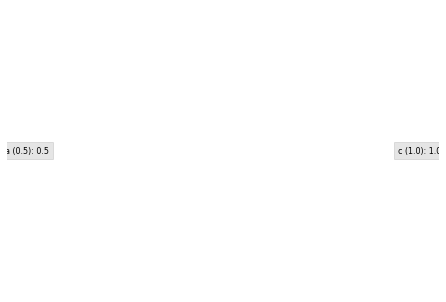

In [48]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

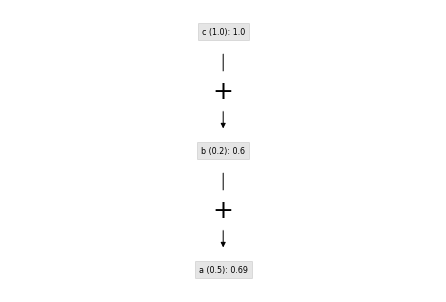

In [49]:
# SquaredDFQuAD violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.2, 1]
atts = []
supps = [('b', 'a'), ('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

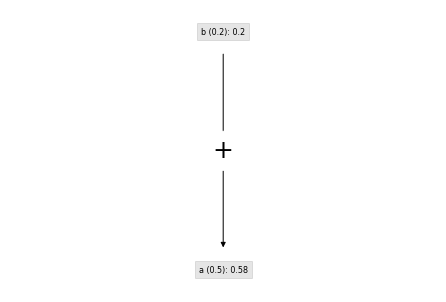

In [50]:
args = ['a', 'b']
initial_strengths = [0.5, 0.2]
atts = []
supps = [('b', 'a')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

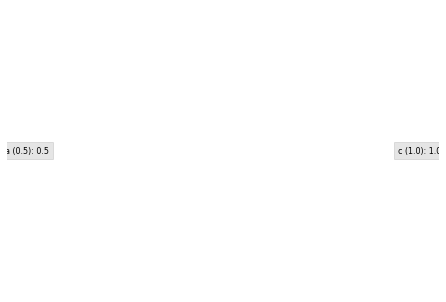

In [51]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model")
visualize(qbaf_0, with_fs=True)

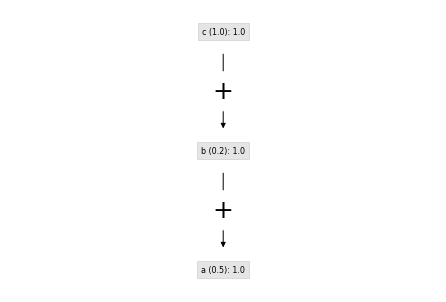

In [52]:
# DFQuAD violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.2, 1]
atts = []
supps = [('b', 'a'), ('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

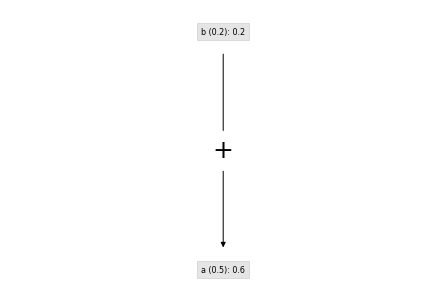

In [53]:
args = ['a', 'b']
initial_strengths = [0.5, 0.2]
atts = []
supps = [('b', 'a')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

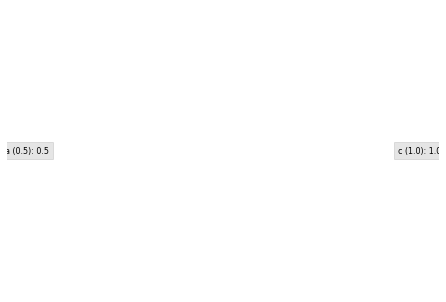

In [54]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="DFQuAD_model")
visualize(qbaf_0, with_fs=True)

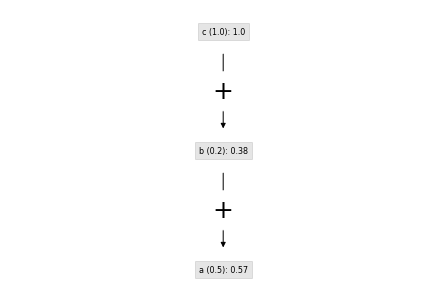

In [55]:
# EulerBased violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.2, 1]
atts = []
supps = [('b', 'a'), ('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

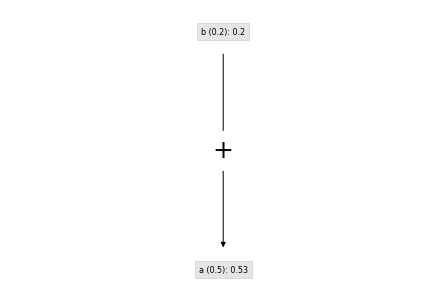

In [56]:
args = ['a', 'b']
initial_strengths = [0.5, 0.2]
atts = []
supps = [('b', 'a')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

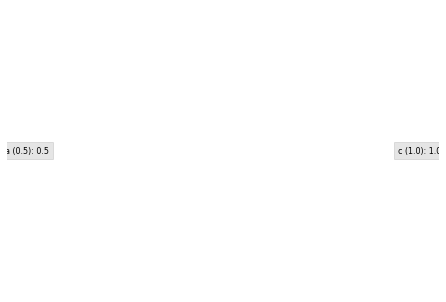

In [57]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBased_model")
visualize(qbaf_0, with_fs=True)

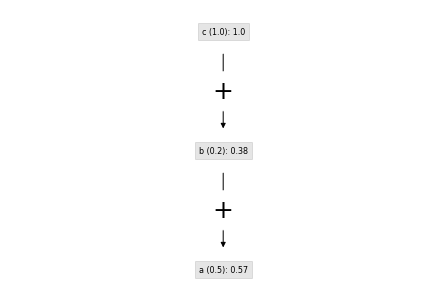

In [58]:
# EulerBased top violates proximity
args = ['a', 'b', 'c']
initial_strengths = [0.5, 0.2, 1]
atts = []
supps = [('b', 'a'), ('c', 'b')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

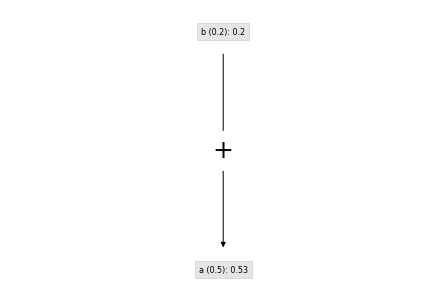

In [59]:
args = ['a', 'b']
initial_strengths = [0.5, 0.2]
atts = []
supps = [('b', 'a')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

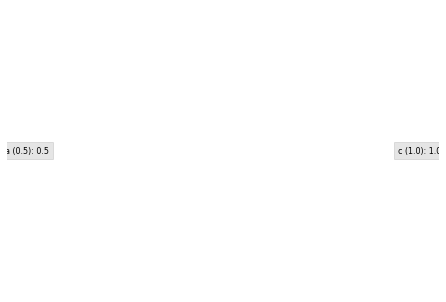

In [60]:
args = ['a', 'c']
initial_strengths = [0.5, 1]
atts = []
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="EulerBasedTop_model")
visualize(qbaf_0, with_fs=True)

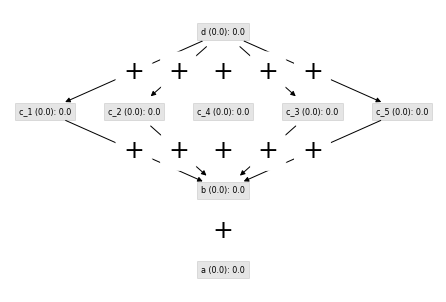

In [61]:
args = ['a', 'b', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'd']
initial_strengths = [0, 0, 0, 0, 0, 0, 0, 0]
atts = []
supps = [('b', 'a'), ('c_1', 'b'), ('c_2', 'b'), ('c_3', 'b'), ('c_4', 'b'), ('c_5', 'b'), ('d', 'c_1'), ('d', 'c_1'), ('d', 'c_2'), ('d', 'c_3'), ('d', 'c_4'), ('d', 'c_5')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
visualize(qbaf_0, with_fs=True)

In [62]:
args = ['a', 'b', 'd']
initial_strengths = [0, 0, 0.001]
atts = []
supps = [('b', 'a')]
for i in range(0, 1000000):
    arg = f'c{i}'
    args.append(arg)
    initial_strengths.append(0)
    supps.append((arg, 'b'))
    supps.append(('d', arg))
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")
# visualize(qbaf_0, with_fs=True)

In [63]:
qbaf_0.final_strengths['a']

0.19999968000740165

In [64]:
args = ['a', 'b', 'd']
initial_strengths = [0, 0.001, 0]
atts = []
supps = [('b', 'a')]
for i in range(0, 1000000):
    arg = f'c{i}'
    args.append(arg)
    initial_strengths.append(0)
    supps.append((arg, 'b'))
    supps.append(('d', arg))
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")

In [65]:
qbaf_0.final_strengths['a']

9.99999000001e-07

In [66]:
# QuadraticEnergy, SquaredDFQuAD, DFQuAD, EulerBased, EulerBasedTop violate proximity, given intrinsic removal ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    initial_strengths = [0.5, 0.1, 0.9]
    atts = []
    supps = [('b', 'a'), ('c', 'b')]
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [0.5, 0.1]
    atts_1 = []
    supps_1 = [('b', 'a')]
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [0.5, 0.9]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    #print(f'Standard removal, {semantics}:')
    #print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    #print(f'Ctrb b to a: {final_strength_a_0 - final_strength_a_2}')
    print(f'Intrinsic removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_1 - final_strength_a_2}')
    
run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
run_example("DFQuAD_model")
run_example("EulerBased_model")
run_example("EulerBasedTop_model")

Intrinsic removal, QuadraticEnergy_model:
Ctrb c to a: 0.09593396477214111
Ctrb b to a: 0.004950495049504955
Intrinsic removal, SquaredDFQuAD_model:
Ctrb c to a: 0.12695924764890287
Ctrb b to a: 0.045454545454545414
Intrinsic removal, DFQuAD_model:
Ctrb c to a: 0.405
Ctrb b to a: 0.050000000000000044
Intrinsic removal, EulerBased_model:
Ctrb c to a: 0.018389194084511784
Ctrb b to a: 0.01693480340541531
Intrinsic removal, EulerBasedTop_model:
Ctrb c to a: 0.018389194084511784
Ctrb b to a: 0.01693480340541531


In [67]:
# QuadraticEnergy, DFQuAD, EulerBased, EulerBasedTop violate proximity, given removal ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    initial_strengths = [0.5, 0.1, 1]
    atts = [('b', 'a'), ('c', 'b')]
    supps = []
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [0.5, 0.1]
    atts_1 = [('b', 'a')]
    supps_1 = []
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [0.5, 1]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    print(f'Standard removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_0 - final_strength_a_2}')
    #print(f'Intrinsic removal, {semantics}:')
    #print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    #print(f'Ctrb b to a: {final_strength_a_1 - final_strength_a_2}')
    
run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
run_example("DFQuAD_model")
run_example("EulerBased_model")
run_example("EulerBasedTop_model")

Standard removal, QuadraticEnergy_model:
Ctrb c to a: 0.0037036122564875207
Ctrb b to a: -0.0012468827930174342
Standard removal, SquaredDFQuAD_model:
Ctrb c to a: 0.021645021645021634
Ctrb b to a: -0.023809523809523836
Standard removal, DFQuAD_model:
Ctrb c to a: 0.04999999999999999
Ctrb b to a: 0.0
Standard removal, EulerBased_model:
Ctrb c to a: 0.008916125816814224
Ctrb b to a: -0.007463892798544758
Standard removal, EulerBasedTop_model:
Ctrb c to a: 0.008916125816814224
Ctrb b to a: -0.007463892798544758


In [68]:
# SquaredDFQuAD violates proximity, given removal ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    initial_strengths = [0.5, 0.01, 1.5]
    atts = [('b', 'a'), ('c', 'b')]
    supps = []
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [0.5, 0.01]
    atts_1 = [('b', 'a')]
    supps_1 = []
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [0.5, 1.5]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']
    print(qbaf_0.final_strengths)

    print(f'Standard removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_0 - final_strength_a_2}')
    
run_example("SquaredDFQuAD_model")


{'c': 1.5, 'b': 0.004, 'a': 0.49800796812749004}
Standard removal, SquaredDFQuAD_model:
Ctrb c to a: 0.0029584631769949965
Ctrb b to a: -0.0019920318725099584


## Shapley and Proximity

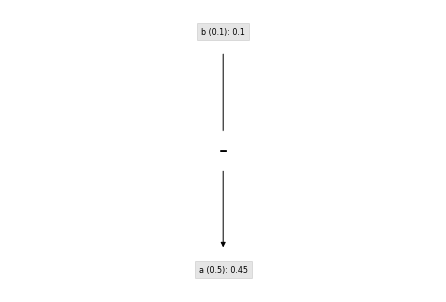

In [69]:
import math
from itertools import chain, combinations

def get_powerset(elements):
    lset = list(elements)
    return chain.from_iterable(combinations(lset, option) for option in range(len(lset) + 1))

def restrict(qbaf, arguments):
    restriction_is = []
    new_args = []
    for arg, strength in qbaf.initial_strengths.items():
        if arg in arguments:
            new_args.append(arg)
            restriction_is.append(strength)
    restriction_atts = [(source, target) for source, target in qbaf.attack_relations.relations if source in arguments and target in arguments]
    restriction_supps = [(source, target) for source, target in qbaf.support_relations.relations if source in arguments and target in arguments]
    return QBAFramework(new_args, restriction_is, restriction_atts, restriction_supps, semantics=qbaf.semantics)   
    
args = ['a', 'b', 'c']
is_a = 0.5
is_b = 0.1
is_c = 0.9
initial_strengths = [is_a, is_b, is_c]
atts = [('b', 'a'), ('c', 'b')]
supps = []
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)
visualize(restrict(qbaf_0, ['a', 'b']), with_fs=True)

b to a, SquaredDFQuAD_model
-0.14583333333333331
c to a, SquaredDFQuAD_model
0.020833333333333315


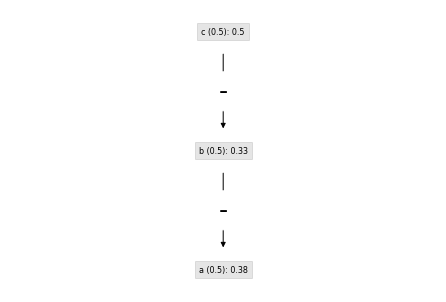

In [70]:
def determine_sctrb(qbaf, argx, arga):
    sub_ctrbs = []
    reduced_args = [arg for arg in qbaf.arguments if arg not in [argx, arga]]
    subsets = get_powerset(reduced_args)
    for subset in subsets:
        lsubset = list(subset)
        qbaf_without = restrict(qbaf, [arg for arg in qbaf.arguments if arg in lsubset + [arga]])
        qbaf_with = restrict(qbaf, [arg for arg in qbaf.arguments if arg in lsubset + [arga, argx]])
        weight = (math.factorial(len(lsubset)) * math.factorial(len(qbaf.arguments)-2-len(lsubset)))/math.factorial(len(qbaf.arguments)-1)
        sub_ctrb = weight * (qbaf_with.final_strengths[arga] - qbaf_without.final_strengths[arga])
        sub_ctrbs.append(sub_ctrb)
        # print(subset)
        # print(sub_ctrb)
        # print('subset', lsubset)
        # print('weight', weight)
        # print('sub ctrb', sub_ctrb)
        # print('w/o weight', (qbaf_with.final_strengths[arga] - qbaf_without.final_strengths[arga]))
        # print('without', qbaf_without.initial_strengths, qbaf_without.attack_relations.relations, qbaf_without.support_relations.relations, qbaf_without.final_strengths[arga])
        # print('with', qbaf_with.initial_strengths, qbaf_with.attack_relations.relations, qbaf_with.support_relations.relations, qbaf_with.final_strengths[arga])
    return sum(sub_ctrbs)
    
args = ['a', 'b', 'c']
is_a = 0.5
is_b = 0.5
is_c = 0.5
initial_strengths = [is_a, is_b, is_c]
atts = [('b', 'a'), ('c', 'b')]
supps = []

def run_example():
    print('b to a, SquaredDFQuAD_model')
    print(determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model"), 'b', 'a'))
    print('c to a, SquaredDFQuAD_model')
    print(determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model"), 'c', 'a'))
    
run_example()
visualize(QBAFramework(args, initial_strengths, atts, supps, semantics="SquaredDFQuAD_model"), with_fs=True)

f to a, QuadraticEnergy_model
-0.0005616575596397327
e to a, QuadraticEnergy_model
4.932615331399619e-05
# f to a minus e to a #, QuadraticEnergy_model
0.0005123314063257365
# ################### #
f to a, DFQuAD_model
-0.037454387604166674
e to a, DFQuAD_model
0.010998481145833329
# f to a minus e to a #, DFQuAD_model
0.026455906458333345
# ################### #


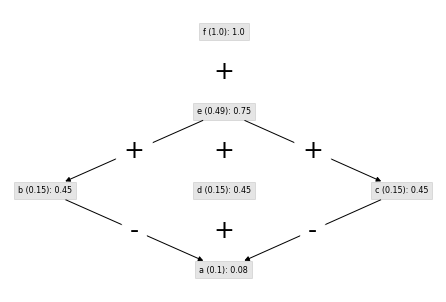

In [71]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f']
    initial_strengths = [0.1, 0.15, 0.15, 0.15, 0.495, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]

    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    if semantics == 'QuadraticEnergy_model':
        visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
run_example("QuadraticEnergy_model")
run_example("DFQuAD_model")


f to a, SquaredDFQuAD_model
0.001941185637998613
e to a, SquaredDFQuAD_model
0.03542976772118808
# f to a minus e to a #, SquaredDFQuAD_model
-0.03348858208318947
# ################### #
f to a, EulerBased_model
-0.0006952321336101686
e to a, EulerBased_model
-0.003130145168964149
# f to a minus e to a #, EulerBased_model
-0.0024349130353539805
# ################### #
f to a, EulerBasedTop_model
-0.00036430635751287245
e to a, EulerBasedTop_model
-0.0018276022903745063
# f to a minus e to a #, EulerBasedTop_model
-0.001463295932861634
# ################### #


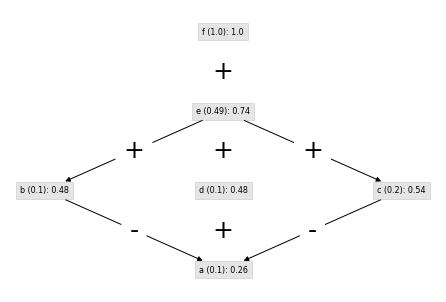

In [72]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f']
    initial_strengths = [0.1, 0.1, 0.2, 0.1, 0.49, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]
    #for i in range(0, 5):
    #    arg = f'c{i}'
    #    args.append(arg)
    #    initial_strengths.append(0.1)
    #    supps.append(('e', arg))
    #    if i % 2 == 0:
    #        atts.append((arg, 'a'))
    #    else:
    #        supps.append((arg, 'a'))
    #    supps.append(('e', arg))

    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    if semantics == 'SquaredDFQuAD_model':
        visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
#run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
#run_example("DFQuAD_model")
run_example("EulerBased_model")
run_example("EulerBasedTop_model")

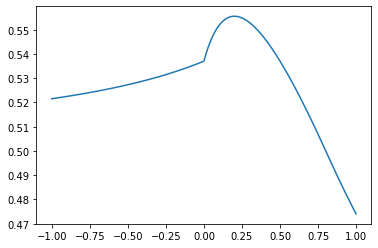

f to a, SquaredDFQuAD_model
-0.00367177522349936
e to a, SquaredDFQuAD_model
0.00044699872286079194
# f to a minus e to a #, SquaredDFQuAD_model
0.0032247765006385683
# ################### #


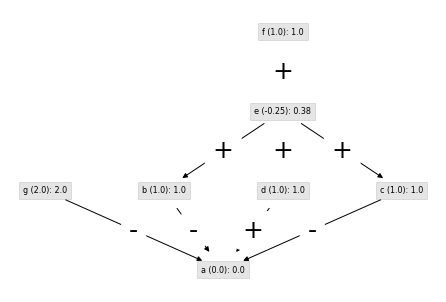

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def run_example_plot(semantics):
    ises = []
    fsas = []
    for ise in range(-1000, 1000):
        fise = ise / 1000
        args = ['a', 'b', 'c', 'd', 'e', 'g']
        initial_strengths = [0.5, 0.1, 0.1, 0.1, fise, 2]
        atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
        supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd')]
        qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
        ises.append(fise)
        fsas.append(qbaf.final_strengths['a'])
    plt.plot(np.array(ises), np.array(fsas))
    plt.show()
    #visualize(qbaf, with_fs=True)
        
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    initial_strengths = [0, 1, 1, 1, -0.25, 1, 2]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    if semantics == 'SquaredDFQuAD_model':
        visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
    
run_example_plot("SquaredDFQuAD_model")
run_example("SquaredDFQuAD_model")
#run_example("EulerBased_model")
#run_example("EulerBasedTop_model")

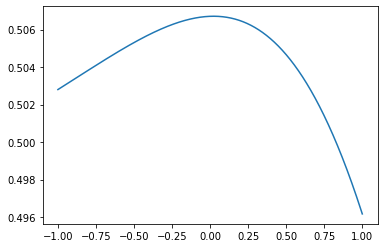

f to a, EulerBased_model
-0.00025911808231329395
e to a, EulerBased_model
-0.00021949357351193995
# f to a minus e to a #, EulerBased_model
3.962450880135401e-05
# ################### #


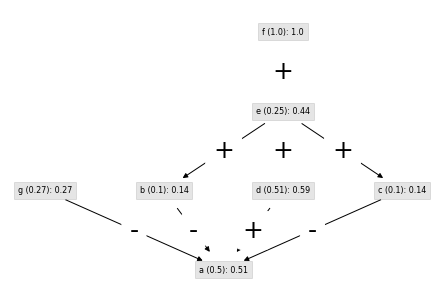

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def run_example_plot(semantics):
    ises = []
    fsas = []
    for ise in range(-1000, 1000):
        fise = ise / 1000
        args = ['a', 'b', 'c', 'd', 'e', 'g']
        initial_strengths = [0.5, 0.1, 0.1, 0.51, fise, 0.27]
        atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
        supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd')]
        qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
        ises.append(fise)
        fsas.append(qbaf.final_strengths['a'])
    plt.plot(np.array(ises), np.array(fsas))
    plt.show()
    #visualize(qbaf, with_fs=True)
        
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    initial_strengths = [0.5, 0.1, 0.1, 0.51, 0.25, 1, 0.27]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    if semantics == 'EulerBased_model':
        visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
    
run_example_plot("EulerBased_model")
#run_example("SquaredDFQuAD_model")
run_example("EulerBased_model")
#run_example("EulerBasedTop_model")

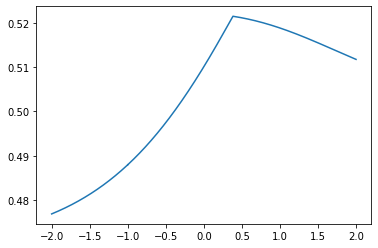

f to a, EulerBasedTop_model
0.0014840923967265884
e to a, EulerBasedTop_model
-0.0008632168950704252
# f to a minus e to a #, EulerBasedTop_model
0.0006208755016561632
# ################### #


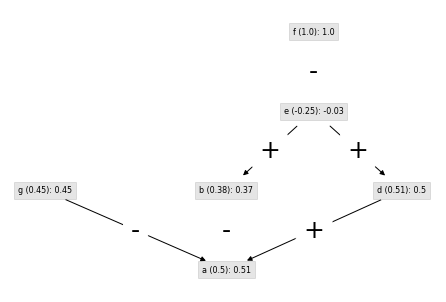

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def run_example_plot(semantics):
    ises = []
    fsas = []
    for ise in range(-2000, 2000):
        fise = ise / 1000
        args = ['a', 'b', 'd', 'e', 'g']
        initial_strengths = [0.5, 0.38, 0.51, fise, 0.45]
        atts = [('b', 'a'), ('g', 'a')]
        supps = [('d', 'a'), ('e', 'b'), ('e', 'd')]
        qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
        ises.append(fise)
        fsas.append(qbaf.final_strengths['a'])
    plt.plot(np.array(ises), np.array(fsas))
    plt.show()
    #visualize(qbaf, with_fs=True)
        
def run_example(semantics):
    args = ['a', 'b', 'd', 'e', 'f', 'g']
    initial_strengths = [0.5, 0.38, 0.51, -0.25, 1, 0.45]
    atts = [('b', 'a'), ('g', 'a'), ('f', 'e')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'd')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    if semantics == 'EulerBasedTop_model':
        visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
    
run_example_plot("EulerBasedTop_model")
#run_example("SquaredDFQuAD_model")
run_example("EulerBasedTop_model")
#run_example("EulerBasedTop_model")

## Shapley and Counterfactuality
### Quadratic Energy

f to a, QuadraticEnergy_model
-0.0005616575596397327
e to a, QuadraticEnergy_model
4.932615331399619e-05
# f to a minus e to a #, QuadraticEnergy_model
0.0005123314063257365
# ################### #


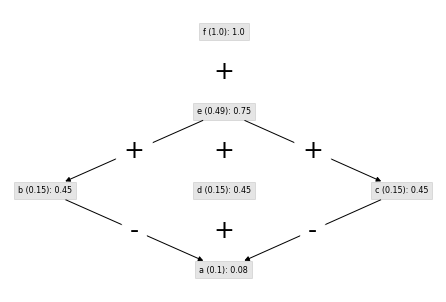

In [214]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f']
    initial_strengths = [0.1, 0.15, 0.15, 0.15, 0.495, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]

    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
run_example("QuadraticEnergy_model")

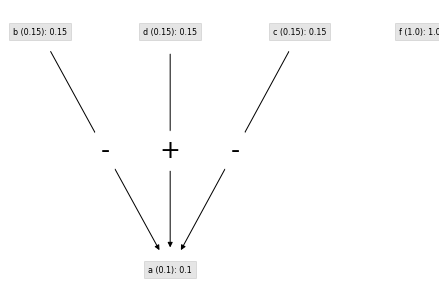

In [215]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'f']
    initial_strengths = [0.1, 0.15, 0.15, 0.15, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a')]
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
run_example("QuadraticEnergy_model")

### DFQuAD

f to a, DFQuAD_model
-0.037454387604166674
e to a, DFQuAD_model
0.010998481145833329
# f to a minus e to a #, DFQuAD_model
0.026455906458333345
# ################### #


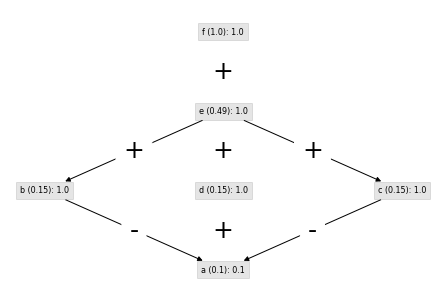

In [216]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f']
    initial_strengths = [0.1, 0.15, 0.15, 0.15, 0.495, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]

    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
run_example("DFQuAD_model")

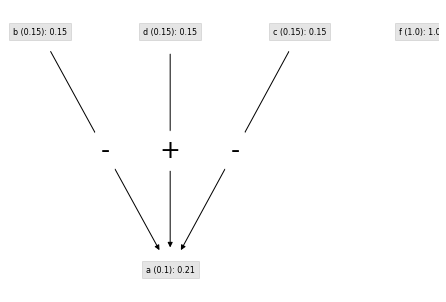

In [217]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'f']
    initial_strengths = [0.1, 0.15, 0.15, 0.15, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('d', 'a')]
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
run_example("DFQuAD_model")

### Euler-based

f to a, EulerBased_model
1.2936145044928343e-05
e to a, EulerBased_model
3.229178853712729e-05
# f to a minus e to a #, EulerBased_model
-1.9355643492198946e-05
# ################### #


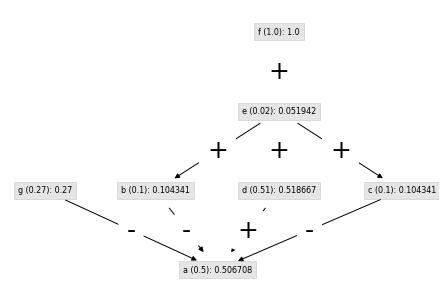

In [269]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    initial_strengths = [0.5, 0.1, 0.1, 0.51, 0.02, 1, 0.27]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True, round_to=6)

run_example("EulerBased_model")

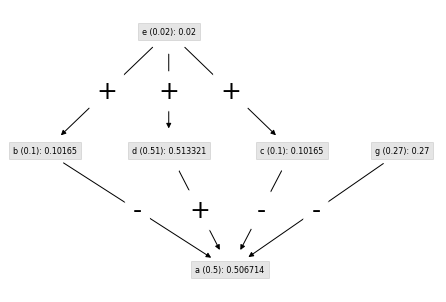

In [270]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'g']
    initial_strengths = [0.5, 0.1, 0.1, 0.51, 0.02, 0.27]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd')]
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True, round_to=6)
    
run_example("EulerBased_model")

### Euler-based Top

f to a, EulerBasedTop_model
0.0023010356634770284
e to a, EulerBasedTop_model
-0.0009176444870274155
# f to a minus e to a #, EulerBasedTop_model
0.001383391176449613
# ################### #


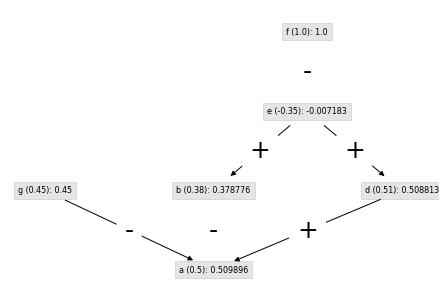

In [287]:
def run_example(semantics):
    args = ['a', 'b', 'd', 'e', 'f', 'g']
    initial_strengths = [0.5, 0.38, 0.51, -0.35, 1, 0.45]
    atts = [('b', 'a'), ('g', 'a'), ('f', 'e')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'd')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True, round_to=6)

run_example("EulerBasedTop_model")

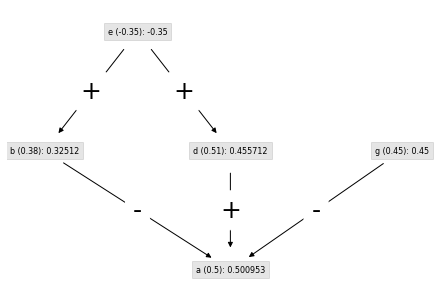

In [288]:
def run_example(semantics):
    args = ['a', 'b', 'd', 'e', 'g']
    initial_strengths = [0.5, 0.38, 0.51, -0.35, 0.45]
    atts = [('b', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'd')]
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True, round_to=6)

run_example("EulerBasedTop_model")

f to a, SquaredDFQuAD_model
0.001078173270046729
e to a, SquaredDFQuAD_model
0.0009158114158360486
# f to a minus e to a #, SquaredDFQuAD_model
0.00016236185421068046
# ################### #


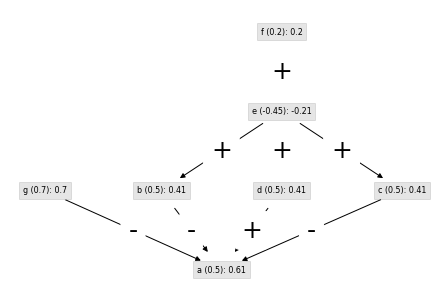

In [140]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
    initial_strengths = [0.5, 0.5, 0.5, 0.5, -0.45, 0.2, 0.7]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a'), ('e', 'b'), ('e', 'c'), ('e', 'd'), ('f', 'e')]
    qbaf = QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}')
    print(f'f to a, {semantics}')
    f_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'f', 'a')
    print(f_to_a)
    print(f'e to a, {semantics}')
    e_to_a = determine_sctrb(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), 'e', 'a')
    print(e_to_a)
    print(f'# f to a minus e to a #, {semantics}')
    print(abs(f_to_a) - abs(e_to_a))
    print('# ################### #')
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
    
run_example("SquaredDFQuAD_model")

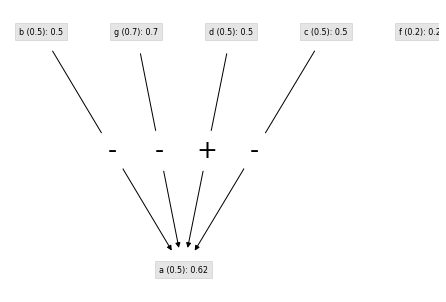

In [141]:
def run_example(semantics):
    args = ['a', 'b', 'c', 'd', 'f', 'g']
    initial_strengths = [0.5, 0.5, 0.5, 0.5, 0.2, 0.7]
    atts = [('b', 'a'), ('c', 'a'), ('g', 'a')]
    supps = [('d', 'a')]
    visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)
    
run_example("SquaredDFQuAD_model")

In [ ]:
### Squared DFQuAD

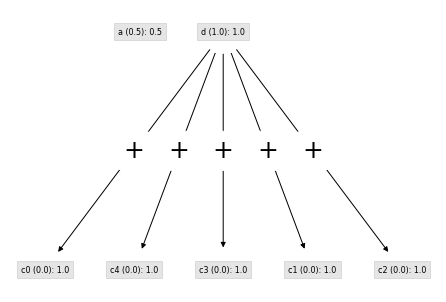

In [80]:
args = ['a', 'd']
initial_strengths = [0.5, 1]
atts = []
supps = []
for i in range(0, 5):
    arg = f'c{i}'
    args.append(arg)
    initial_strengths.append(0)
    supps.append(('d', arg))
visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)

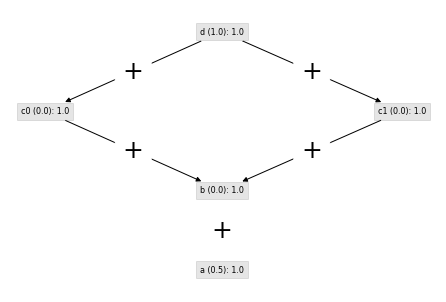

In [81]:
args = ['a', 'b', 'd']
initial_strengths = [0.5, 0, 1]
atts = []
supps = [('b', 'a')]
for i in range(0, 2):
    arg = f'c{i}'
    args.append(arg)
    initial_strengths.append(0)
    supps.append((arg, 'b'))
    supps.append(('d', arg))
visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)

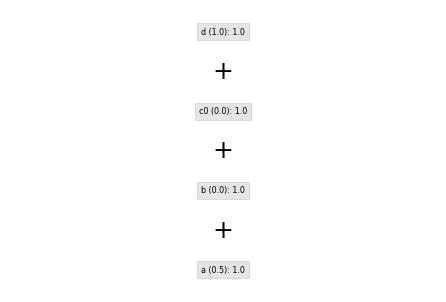

In [82]:
args = ['a', 'b', 'd']
initial_strengths = [0.5, 0, 1]
atts = []
supps = [('b', 'a')]
for i in range(0, 1):
    arg = f'c{i}'
    args.append(arg)
    initial_strengths.append(0)
    supps.append((arg, 'b'))
    supps.append(('d', arg))
visualize(QBAFramework(args, initial_strengths, atts, supps, semantics=f'{semantics}'), with_fs=True)

In [83]:
# QuadraticEnergy, SquaredDFQuAD, DFQuAD, EulerBased, EulerBasedTop violate proximity, given shapley ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    is_a = 0.5
    is_b = 0.1
    is_c = 0.9
    initial_strengths = [is_a, is_b, is_c]
    atts = [('b', 'a'), ('c', 'b')]
    supps = []
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [is_a, is_b]
    atts_1 = [('b', 'a')]
    supps_1 = []
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [is_a, is_c]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    print(f'Shapley, {semantics}:')
    print(f'Ctrb c to a: {((final_strength_a_0 - final_strength_a_1))}')
    print(f'Ctrb b to a: {((final_strength_a_0 - final_strength_a_2) + (final_strength_a_1 - is_a))}')
    
run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
#run_example("DFQuAD_model")
#run_example("EulerBased_model")
#run_example("EulerBasedTop_model")

Shapley, QuadraticEnergy_model:
Ctrb c to a: 0.003428934537043349
Ctrb b to a: -0.006472055561966561
Shapley, SquaredDFQuAD_model:
Ctrb c to a: 0.020454545454545447
Ctrb b to a: -0.07045454545454549


In [84]:
# QuadraticEnergy, SquaredDFQuAD, DFQuAD, EulerBased, EulerBasedTop violate proximity, given shapley ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    is_a = 0.5
    is_b = 0.1
    is_c = 0.9
    initial_strengths = [is_a, is_b, is_c]
    atts = []
    supps = [('b', 'a'), ('c', 'b')]
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [is_a, is_b]
    atts_1 = []
    supps_1 = [('b', 'a')]
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [is_a, is_c]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    print(f'Shapley, {semantics}:')
    print(f'Ctrb c to a: {((final_strength_a_0 - final_strength_a_1))}')
    print(f'Ctrb b to a: {((final_strength_a_0 - final_strength_a_2) + (final_strength_a_1 - is_a))}')
    
run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
run_example("DFQuAD_model")
run_example("EulerBased_model")
run_example("EulerBasedTop_model")

Shapley, QuadraticEnergy_model:
Ctrb c to a: 0.09593396477214111
Ctrb b to a: 0.10583495487115102
Shapley, SquaredDFQuAD_model:
Ctrb c to a: 0.12695924764890287
Ctrb b to a: 0.2178683385579937
Shapley, DFQuAD_model:
Ctrb c to a: 0.405
Ctrb b to a: 0.5050000000000001
Shapley, EulerBased_model:
Ctrb c to a: 0.018389194084511784
Ctrb b to a: 0.052258800895342405
Shapley, EulerBasedTop_model:
Ctrb c to a: 0.018389194084511784
Ctrb b to a: 0.052258800895342405


In [85]:
# QuadraticEnergy, SquaredDFQuAD, DFQuAD violate counterfactuality, given intrinsic removal ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    initial_strengths = [1, 0, 1]
    atts = [('b', 'a')]
    supps = [('c', 'b')]
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [1, 0]
    atts_1 = [('b', 'a')]
    supps_1 = []
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [1, 1]
    atts_2 = []
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    print(f'Standard removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_0 - final_strength_a_2}')
    print(f'Intrinsic removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_1 - final_strength_a_2}')
    
run_example("QuadraticEnergy_model")
run_example("SquaredDFQuAD_model")
run_example("DFQuAD_model")
run_example("EulerBased_model")
run_example("EulerBasedTop_model")

Standard removal, QuadraticEnergy_model:
Ctrb c to a: -0.19999999999999996
Ctrb b to a: -0.19999999999999996
Intrinsic removal, QuadraticEnergy_model:
Ctrb c to a: -0.19999999999999996
Ctrb b to a: 0.0
Standard removal, SquaredDFQuAD_model:
Ctrb c to a: -0.33333333333333326
Ctrb b to a: -0.33333333333333326
Intrinsic removal, SquaredDFQuAD_model:
Ctrb c to a: -0.33333333333333326
Ctrb b to a: 0.0
Standard removal, DFQuAD_model:
Ctrb c to a: -1.0
Ctrb b to a: -1.0
Intrinsic removal, DFQuAD_model:
Ctrb c to a: -1.0
Ctrb b to a: 0.0
Standard removal, EulerBased_model:
Ctrb c to a: 0.0
Ctrb b to a: 0.0
Intrinsic removal, EulerBased_model:
Ctrb c to a: 0.0
Ctrb b to a: 0.0
Standard removal, EulerBasedTop_model:
Ctrb c to a: 0.0
Ctrb b to a: 0.0
Intrinsic removal, EulerBasedTop_model:
Ctrb c to a: 0.0
Ctrb b to a: 0.0


0.3138105718617563 0.4245224032141739 0.3665218026227227
Standard removal, EulerBased_model:
Ctrb c to a: -0.11071183135241758
Ctrb b to a: -0.0527112307609664
Intrinsic removal, EulerBased_model:
Ctrb c to a: -0.11071183135241758
Ctrb b to a: -0.04124612911013392
0.3665218026227227 0.4245224032141739 0.3665218026227227
Standard removal, EulerBasedTop_model:
Ctrb c to a: -0.05800060059145118
Ctrb b to a: 0.0
Intrinsic removal, EulerBasedTop_model:
Ctrb c to a: -0.05800060059145118
Ctrb b to a: 0.0


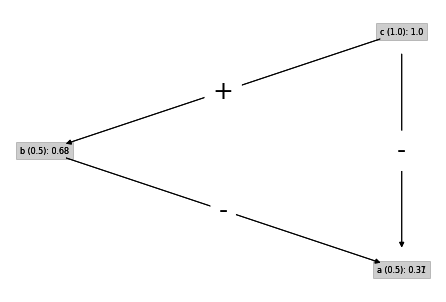

In [86]:
# EulerBased, EulerBasedTop violate counterfactuality, given intrinsic removal ctrb function

def run_example(semantics):
    # Full QBAG
    args = ['a', 'b', 'c']
    initial_strengths = [0.5, 0.5, 1]
    atts = [('b', 'a'), ('c', 'a')]
    supps = [('c', 'b')]
    qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics=semantics)

    # QBAG without c
    args_1 = ['a', 'b']
    initial_strengths_1 = [0.5, 0.5]
    atts_1 = [('b', 'a')]
    supps_1 = []
    qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics=semantics)
    
    # QBAG without support from c to b
    args_1b = ['a', 'b', 'c']
    initial_strengths_1b = [0.5, 0.5, 1]
    atts_1b = [('b', 'a'), ('c', 'a')]
    supps_1b = []
    qbaf_1b = QBAFramework(args_1b, initial_strengths_1b, atts_1b, supps_1b, semantics=semantics)

    # QBAG without b
    args_2 = ['a', 'c']
    initial_strengths_2 = [0.5, 1]
    atts_2 = [('c', 'a')]
    supps_2 = []
    qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics=semantics)

    final_strength_a_0 = qbaf_0.final_strengths['a']
    final_strength_a_1 = qbaf_1.final_strengths['a']
    final_strength_a_1b = qbaf_1b.final_strengths['a']
    final_strength_a_2 = qbaf_2.final_strengths['a']

    print(final_strength_a_0, final_strength_a_1, final_strength_a_2)
    print(f'Standard removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_0 - final_strength_a_2}')
    print(f'Intrinsic removal, {semantics}:')
    print(f'Ctrb c to a: {final_strength_a_0 - final_strength_a_1}')
    print(f'Ctrb b to a: {final_strength_a_1b - final_strength_a_2}')
    visualize(qbaf_0, with_fs=True)

run_example("EulerBased_model")
run_example("EulerBasedTop_model")
